In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.getenv("GROQ_API_KEY")
model="moonshotai/kimi-k2-instruct-0905"

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name=model)
llm.invoke("Hello")

AIMessage(content='Hi! How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 27, 'total_tokens': 37, 'completion_time': 0.026062187, 'completion_tokens_details': None, 'prompt_time': 0.009283221, 'prompt_tokens_details': None, 'queue_time': 0.284132908, 'total_time': 0.035345408}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019babfc-bf4d-71f1-ad15-437312940876-0', usage_metadata={'input_tokens': 27, 'output_tokens': 10, 'total_tokens': 37})

In [4]:
import langgraph
# Available inputs for langgraph.graph:
# - StateGraph: build stateful graphs
# - MessageGraph: build chatbot-style message-passing graphs
# - Graph: base graph class
# - END: special node marking the end of a graph
# - START: special node marking the start of a graph



In [ ]:


from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import MessagesState, StateGraph, START, END
from IPython.display import Image, display


ModuleNotFoundError: No module named 'Langraph'

In [6]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [7]:
from langchain_core.messages import HumanMessage

state = {"messages": [HumanMessage(content="Hi! Akshay")]}
call_model(state)

{'messages': [AIMessage(content='Hey Akshay! What’s up?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 31, 'total_tokens': 41, 'completion_time': 0.032895895, 'completion_tokens_details': None, 'prompt_time': 0.010132635, 'prompt_tokens_details': None, 'queue_time': 0.283186024, 'total_time': 0.04302853}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019babfc-c195-7e93-9fb3-d14454b4013c-0', usage_metadata={'input_tokens': 31, 'output_tokens': 10, 'total_tokens': 41})]}

In [9]:
workflow = StateGraph(MessagesState)
workflow.add_node("myBot", call_model)
workflow.add_edge(START, "myBot")
workflow.add_edge("myBot", END)
app = workflow.compile()


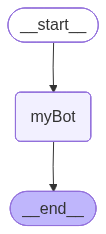

In [10]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
input = {"messages": [HumanMessage(content="Hi! Akshay")]}
app.invoke(input)
for output in app.stream(input):
    for key, value in output.items():
        print(f"Output from node {key} node")
        print("++++++++++++++++")
        print(key, value)

Output from node myBot node
++++++++++++++++
myBot {'messages': [AIMessage(content='Hi Akshay! How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 31, 'total_tokens': 44, 'completion_time': 0.022357054, 'completion_tokens_details': None, 'prompt_time': 0.010220826, 'prompt_tokens_details': None, 'queue_time': 0.285273693, 'total_time': 0.03257788}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_3312304636', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bac03-d606-79a0-aad2-94b8bd7eb41e-0', usage_metadata={'input_tokens': 31, 'output_tokens': 13, 'total_tokens': 44})]}


In [18]:
from langchain_core.tools import tool
from pinecone.db_data.dataclasses import search_query

@tool
def search(query:str):
    '''This is a custom tool for fetching weather'''
    
    if "delhi" in query.lower():
        return "The temp is Delhi is 45 degrees"
    else:
        return "The temp is 25 degrees and cloudy"

search.invoke("What is the temp is delhi?")

'The temp is Delhi is 45 degrees'

In [19]:
tools = [search]
llm_with_tools = llm.bind_tools(tools)
resp= llm_with_tools.invoke("What is the temp is delhi?")
resp.content

"I'll check the current temperature in Delhi for you."

In [35]:
def call_model(state: MessagesState):
    ques = state["messages"]
    # The LLM takes a list of messages and returns an AIMessage object
    response = llm_with_tools.invoke(ques)
    
    # Return the response object directly inside the list
    # MessagesState will automatically handle the merging/appending
    return {"messages": [response]}


In [36]:
def router(state:MessagesState):
    message = state["messages"]
    last_message = message[-1]
    if last_message.tool_calls:
        return "tools"
    else:
        return END;

In [37]:
from langgraph.prebuilt import ToolNode
tool_node = ToolNode(tools)


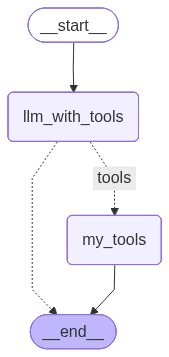

In [45]:
workflow1 = StateGraph(MessagesState)
workflow1.add_node("llm_with_tools", call_model)
workflow1.add_node("my_tools", tool_node)
workflow1.add_edge(START, "llm_with_tools")
workflow1.add_conditional_edges("llm_with_tools", router, {"tools":"my_tools", END:END})
app1 = workflow1.compile()
display(Image(app1.get_graph().draw_mermaid_png()))


In [46]:
input = {"messages": [HumanMessage(content="Hi! Akshay")]}

res = app1.invoke(input)
res["messages"][-1].content

'Hey Akshay! How can I help you today?'

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


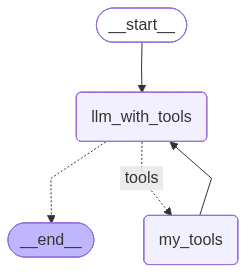

In [49]:
workflow1.add_edge("my_tools","llm_with_tools")
app2 = workflow1.compile()
display(Image(app2.get_graph().draw_mermaid_png()))


In [ ]:
input = {"messages": [HumanMessage(content="What is the weather in delhi?")]}

res = app2.invoke(input)
res["messages"][-1].content

'It’s currently 45 °C in Delhi.'

In [51]:
input = {"messages": [HumanMessage(content="What is the weather in mumbai?")]}

res = app2.invoke(input)
res["messages"][-1].content

'The weather in Mumbai is 25 degrees and cloudy.'

### Add a memory to our workflow

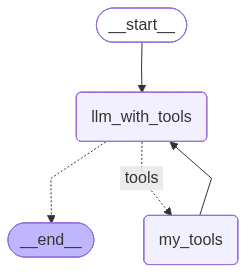

In [56]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

workflow2 = StateGraph(MessagesState)
workflow2.add_node("llm_with_tools", call_model)
workflow2.add_node("my_tools", tool_node)
workflow2.set_entry_point("llm_with_tools")
workflow2.add_conditional_edges("llm_with_tools", router, {"tools": "my_tools", END:END})
workflow2.add_edge("my_tools","llm_with_tools")
app3 = workflow2.compile(checkpointer=memory)
display(Image(app2.get_graph().draw_mermaid_png()))


In [57]:
config = {"configurable": {"thread_id": "1"}}

input = {"messages": [HumanMessage(content="What is the weather in bangalore?")]}

events = app3.stream(input, config=config)
for event in events:
    print(event)

memory.get(config)


{'llm_with_tools': {'messages': [AIMessage(content="I'll help you check the weather in Bangalore.", additional_kwargs={'tool_calls': [{'id': 'functions.search:0', 'function': {'arguments': '{"query":"weather in bangalore"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 98, 'total_tokens': 126, 'completion_time': 0.098640181, 'completion_tokens_details': None, 'prompt_time': 0.060842593, 'prompt_tokens_details': None, 'queue_time': 0.311563189, 'total_time': 0.159482774}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bad4a-3887-7193-a5a0-01002e8cedf1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in bangalore'}, 'id': 'functions.search:0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 98, 'output_tokens': 28, 'total_tokens': 126})

{'v': 4,
 'ts': '2026-01-11T13:41:22.438700+00:00',
 'id': '1f0eef33-7849-6df4-8003-356c89eef891',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.6371017651652814',
  'messages': '00000000000000000000000000000005.0.5871637531303898',
  'branch:to:llm_with_tools': '00000000000000000000000000000005.0.5871637531303898',
  'branch:to:my_tools': '00000000000000000000000000000004.0.08173585082828616'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.8204450536811139'},
  'llm_with_tools': {'branch:to:llm_with_tools': '00000000000000000000000000000004.0.08173585082828616'},
  'my_tools': {'branch:to:my_tools': '00000000000000000000000000000003.0.6749367039852816'}},
 'updated_channels': ['messages'],
 'channel_values': {'messages': [HumanMessage(content='What is the weather in bangalore?', additional_kwargs={}, response_metadata={}, id='dbe503e0-72a1-4d05-8bf0-5f75f8663ce0'),
   AIMessage(content="I'll help you check